In [91]:
import nltk
import pandas as pd
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Метрики
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [92]:
df = pd.read_csv('../ready.csv').dropna()

In [93]:
# Есть ли пропуски:
print(df.isnull().sum())
# Есть ли дубликаты
print(df.duplicated().any())
print(len(df))

Unnamed: 0.2                       0
Unnamed: 0.1                       0
Unnamed: 0                         0
ucid                               0
text_employer                      0
ACTION_ITEM_RESULT_PRODUCT_NAME    0
dtype: int64
False
42620


In [94]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df.ACTION_ITEM_RESULT_PRODUCT_NAME = le.fit_transform(df.ACTION_ITEM_RESULT_PRODUCT_NAME)

In [95]:
X, y = df.text_employer, df.ACTION_ITEM_RESULT_PRODUCT_NAME

# RandomUnderSampler

In [96]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X.values.reshape(-1, 1), y)

## TfidfVectorizer

In [97]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
_, X_test, _, y_test = train_test_split(X, y, test_size=0.05, random_state=21)

In [98]:
tfidfconverter = TfidfVectorizer(max_features=3000, min_df=5, max_df=0.7, stop_words=stopwords.words('russian'))
tfidfconverter.fit(pd.DataFrame(X_train)[0])

TfidfVectorizer(max_df=0.7, max_features=3000, min_df=5,
                stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
                            'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                            'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
                            'по', 'только', 'ее', 'мне', ...])

In [99]:
X_train_vect = tfidfconverter.transform(pd.DataFrame(X_train)[0])
X_val_vect = tfidfconverter.transform(pd.DataFrame(X_val)[0])
X_test_vect = tfidfconverter.transform(X_test)


In [100]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train_vect, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

# Валидация модели на сбалансированном датасете

In [101]:
y_pred = rf.predict(X_val_vect)
print(confusion_matrix(y_true=y_val, y_pred=y_pred))
print(classification_report(y_true=y_val, y_pred=y_pred))

[[949 100 203  40]
 [ 82 963 208  47]
 [ 75 146 971  83]
 [ 67  74 154 956]]
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1292
           1       0.75      0.74      0.75      1300
           2       0.63      0.76      0.69      1275
           3       0.85      0.76      0.80      1251

    accuracy                           0.75      5118
   macro avg       0.76      0.75      0.75      5118
weighted avg       0.76      0.75      0.75      5118



# Тест модели на полном датасете

In [102]:
y_pred = rf.predict(X_test_vect)
print(confusion_matrix(y_true=y_test, y_pred=y_pred))
print(classification_report(y_true=y_test, y_pred=y_pred))
print(accuracy_score(y_true=y_test, y_pred=y_pred))

[[768  54 131  17]
 [ 26 492  90  29]
 [ 12  17 281   9]
 [  4   2   5 194]]
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       970
           1       0.87      0.77      0.82       637
           2       0.55      0.88      0.68       319
           3       0.78      0.95      0.85       205

    accuracy                           0.81      2131
   macro avg       0.79      0.85      0.80      2131
weighted avg       0.85      0.81      0.82      2131

0.8141717503519474


In [103]:
import itertools
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[768  54 131  17]
 [ 26 492  90  29]
 [ 12  17 281   9]
 [  4   2   5 194]]


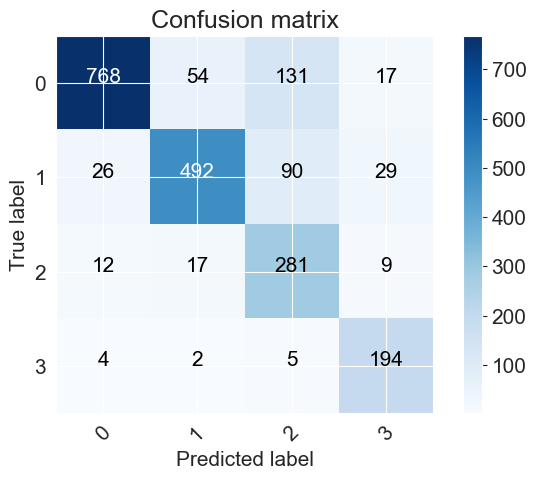

In [104]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_confusion_matrix(cnf_matrix, classes=['0', '1', '2', '3'],
                         title='Confusion matrix')

plt.savefig('./c_matrix.png')

In [105]:
import joblib


joblib.dump(tfidfconverter, '../models/tfidfconverter.pkl')
joblib.dump(rf, '../models/randomforest.pkl')

['../models/randomforest.pkl']